# Spatial Filtering Demo

Here we demonstrate what level of signal remains after performing `dolphin.filtering.filter_long_wavelength`.
We make two synthetic subsidence signals (one Gaussian blob, one cylinder). 
Since the cylinder has much sharper edges, it will respond differently to the high pass filter.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import ultraplot as uplt

import dolphin.filtering

plt.rcParams["image.cmap"] = "RdBu_r"

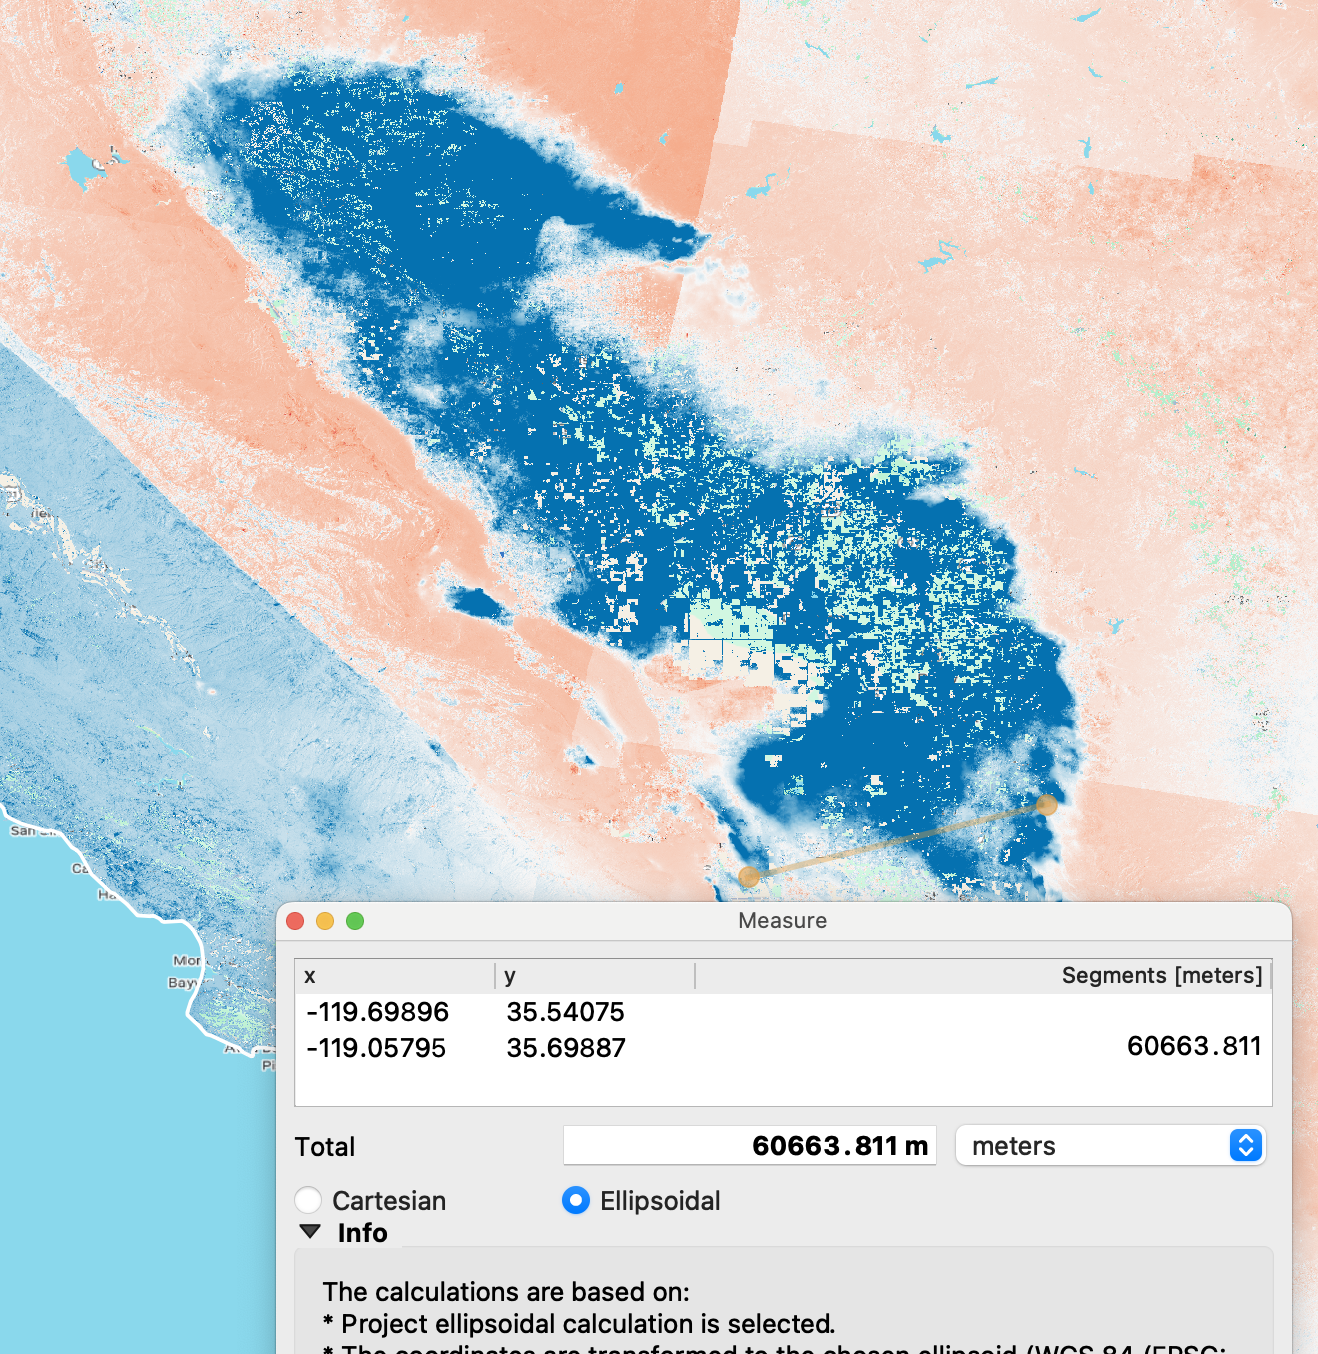

The central valley blob looks about **60 km wide**ish, sometimes larger.

## Set up the synthetic signal functions

In [ ]:

def gaussian(
    shape: tuple[int, int],
    sigma: float | tuple[float, float],
    amp: float,
) -> np.ndarray:
    """Create a 2D Gaussian of given shape and width.

    Parameters
    ----------
    shape : tuple[int, int]
        (rows, cols) of the output array
    sigma : float or tuple[float, float]
        Standard deviation of the Gaussian.
        If one float provided, makes an isotropic Gaussian.
        Otherwise, uses [sigma_row, sigma_col] to make elongated Gaussian.
    amp : float
        Peak height of the Gaussian.

    Returns
    -------
    np.ndarray
        2D array containing the Gaussian

    """
    rows, cols = shape
    if not isinstance(sigma, tuple):
        sigma = (sigma, sigma)
    sy, sx = sigma

    row = rows // 2
    col = cols // 2

    # Create coordinate grids
    y, x = np.ogrid[:rows, :cols]

    # Calculate the 2D Gaussian
    g = np.exp(
        -((x - col) ** 2.0 / (2.0 * sx**2.0) + (y - row) ** 2.0 / (2.0 * sy**2.0))
    )
    # Set the peak amplitude to the provided `amp`
    return g / g.max() * amp


def create_cylinder(
    shape: tuple[int, int],
    resolution: float,
    bowl_size_meters: float,
    bowl_amplitude: float,
) -> np.ndarray:
    """Create a 2D array representing a cylinder/bowl in the middle of the image.

    Parameters
    ----------
    shape : tuple
        (height, width) of the image in pixels
    resolution : float
        spatial resolution in meters per pixel
    bowl_size_meters : float
        diameter of the bowl in meters
    bowl_amplitude : float
        height/depth of the bowl

    Returns
    -------
    np.ndarray:
        2D numpy array with the bowl shape

    """
    height, width = shape
    bowl_size_pixels = bowl_size_meters / resolution

    # Create coordinate grids
    y, x = np.ogrid[:height, :width]

    # Calculate center coordinates
    center_y, center_x = height // 2, width // 2

    # Calculate distance from center for each pixel
    dist_from_center = np.sqrt((y - center_y) ** 2 + (x - center_x) ** 2)

    # Create the bowl shape - zero outside the bowl radius, amplitude inside
    bowl = np.zeros(shape)
    bowl[dist_from_center <= bowl_size_pixels / 2] = bowl_amplitude

    return bowl


In [31]:
shape = (2558, 3144)
resolution = 90
bowl_size_meters = 65_000
bowl_size_pixels = bowl_size_meters / resolution
print("Size of the bowl, in pixels: ", bowl_size_pixels)
bowl_amplitude = -10

Size of the bowl, in pixels:  722.2222222222222

## Run the filter for a range of cutoffs

In [32]:
cutoffs = [10_000, 25_000, 50_000, 75_000, 100_000]


In [11]:
img_cyl = create_cylinder(
    shape, resolution, bowl_size_meters, bowl_amplitude
).astype("float32")
img_blob = gaussian(
    shape, sigma=bowl_size_pixels/2, amp=bowl_amplitude
).astype("float32")

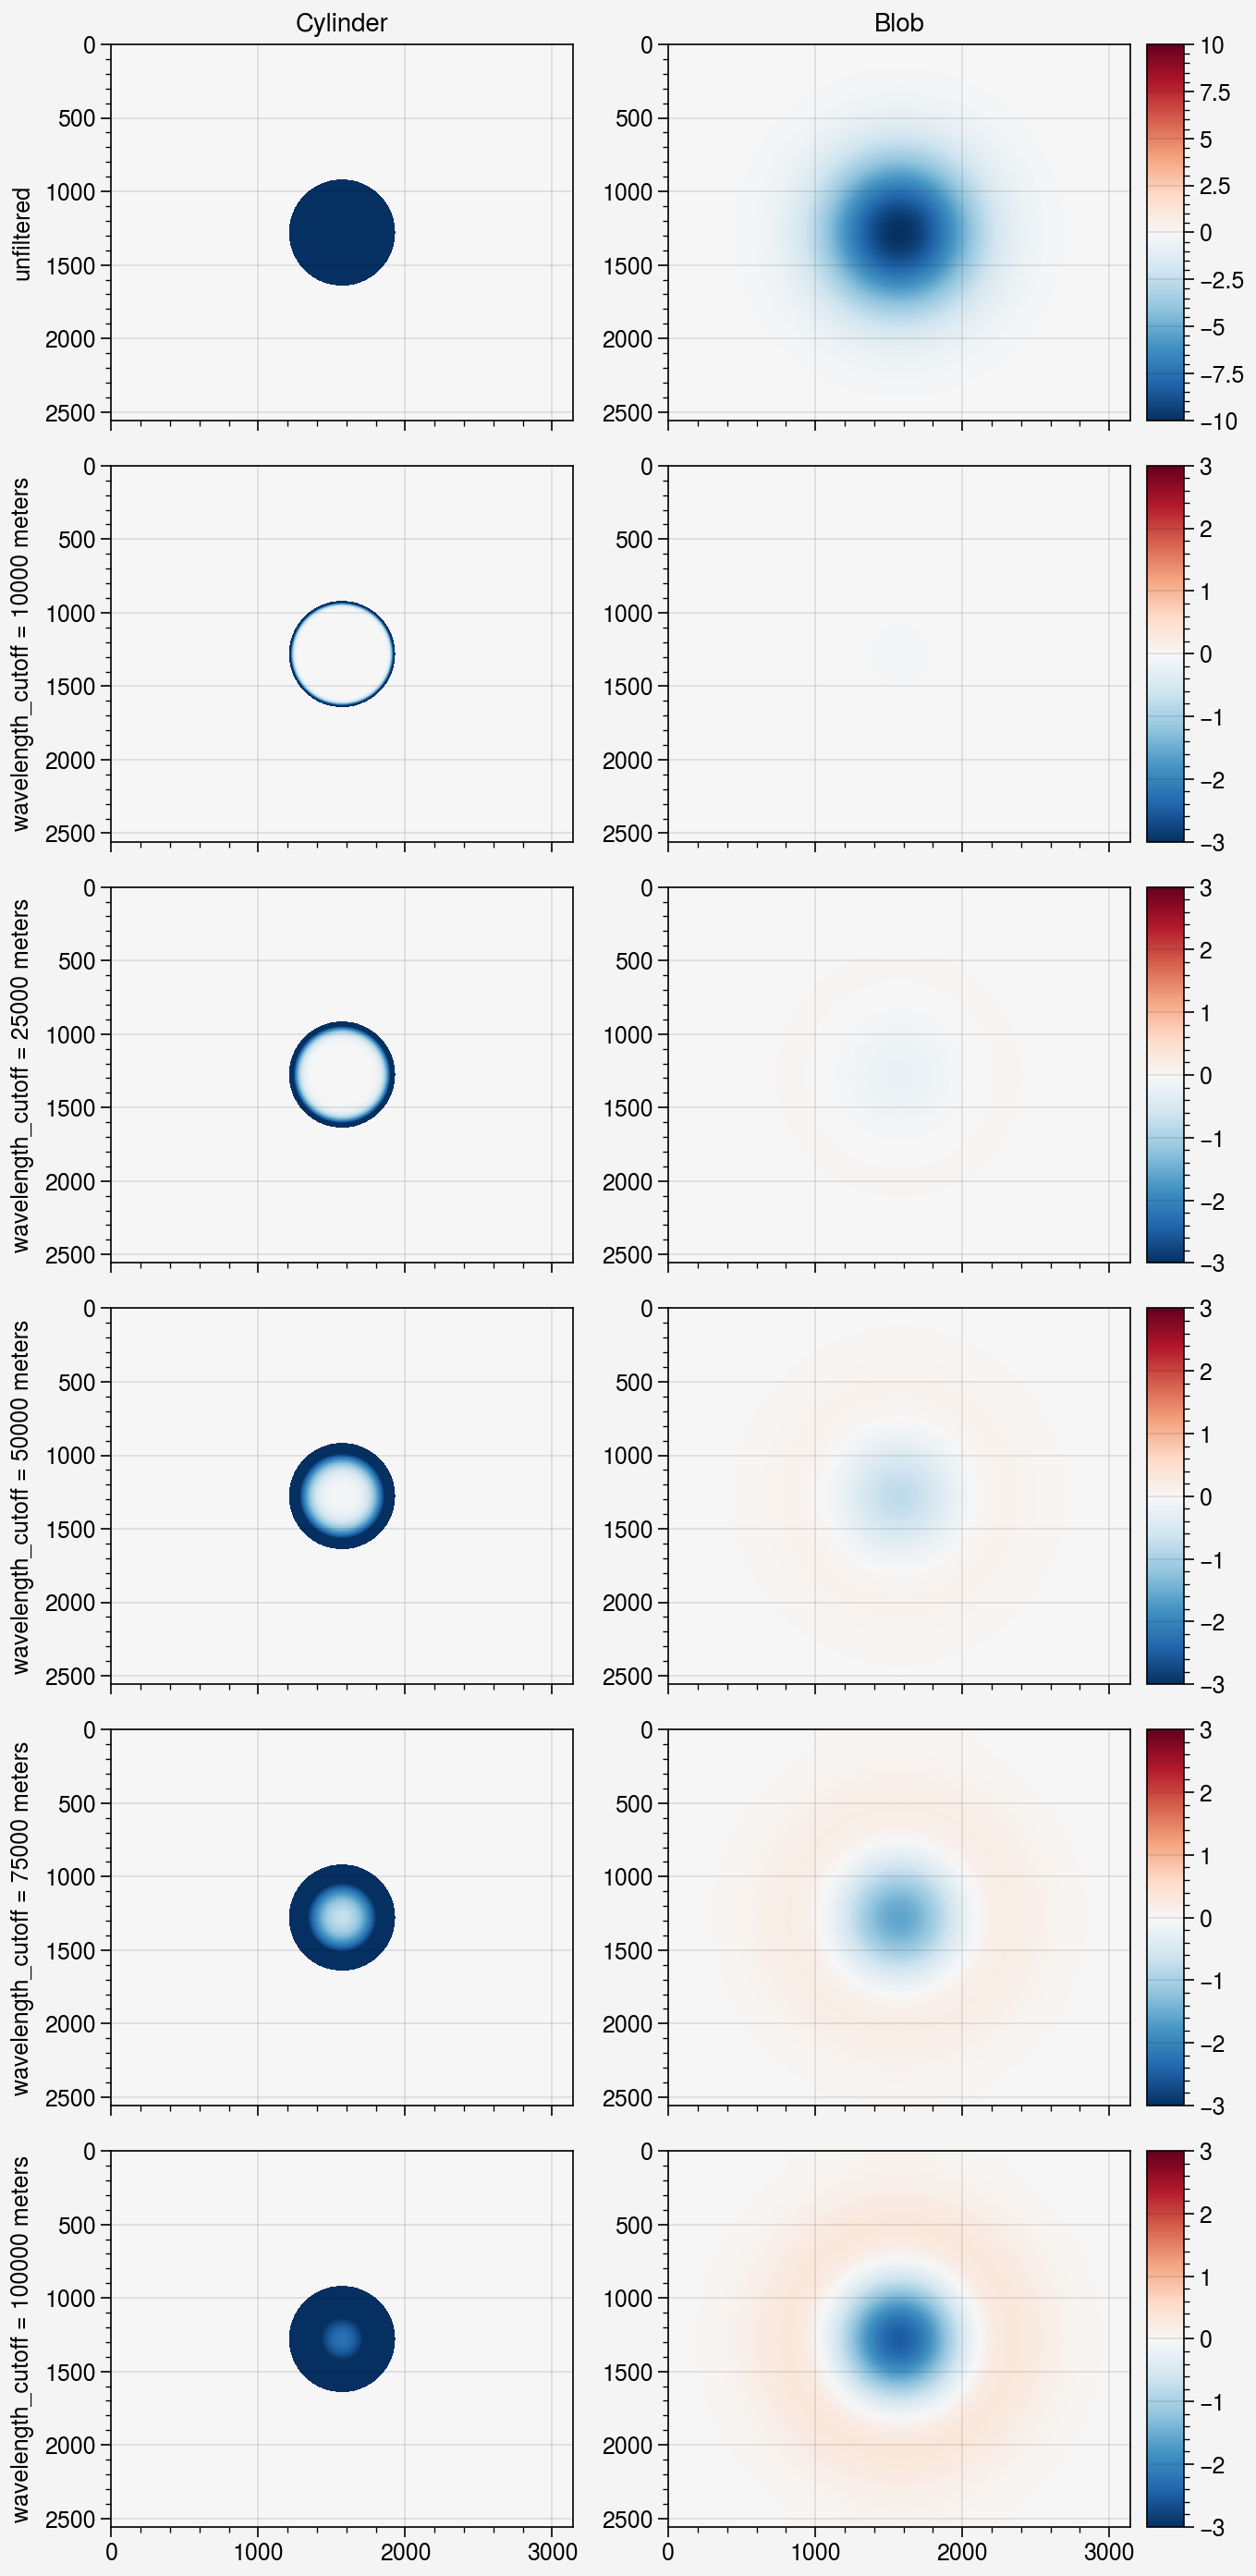

In [27]:
vm = 3

fig, axes = uplt.subplots(ncols=2, nrows = len(cutoffs)+1, sharey=False)
ax = axes[0]
ax.set_title("Cylinder")
axim = ax.imshow(img_cyl, vmax=10, vmin=-10)
ax.set_ylabel("unfiltered")

ax = axes[1]
axim = ax.imshow(img_blob, vmax=10, vmin=-10)
ax.set_title("Blob")

fig.colorbar(axim, ax=ax)


for i, wavelength_cutoff in enumerate(cutoffs):

    kwargs = {
        "bad_pixel_mask": np.zeros(shape, dtype=bool),
        "wavelength_cutoff": wavelength_cutoff,
        "pixel_spacing": resolution,
    }
    img_cyl_filt = dolphin.filtering.filter_long_wavelength(img_cyl, **kwargs)
    img_blob_filt = dolphin.filtering.filter_long_wavelength(img_blob, **kwargs)

    ax = axes[i+1,0]
    axim = ax.imshow(img_cyl_filt, vmax=vm, vmin=-vm)
    ax.set_ylabel(f"{wavelength_cutoff = } meters")

    ax = axes[i+1,1]
    axim = ax.imshow(img_blob_filt, vmax=vm, vmin=-vm)
    fig.colorbar(axim, ax=ax)


**Comments**

- When the cutoff is well below the size of the feature, the Gaussian blob is removed
- The edges of the cylinder (being a high-frequency step function) remain for all filter sizes
- Filtering a smoother subsidence feature leaves a small amount of uplift around the edges